In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import backend as k
from keras.layers import InputLayer
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
from keras.datasets import mnist
from keras import backend as K
from keras import regularizers
from keras import optimizers
from keras.layers.core import Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import cv2
import pickle
import pandas as pd
from keras import applications
from sklearn.model_selection import train_test_split

############## Hyperparameters #############

learning_rate = 1e-5
weight_decay = 0.0005
lr_decay = 1e-6
lr_drop = 20
maxepochs = 25

################ Optimizers ###############

# optim = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

optim = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=lr_decay, amsgrad=False)

#optim = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=lr_decay)

# optim = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

Using TensorFlow backend.


In [8]:
################ MNIST ######################
batch_size = 128
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
#more reshaping
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('X_train shape:', x_train.shape) #X_train shape: (60000, 28, 28, 1)

num_category = 10
y_train = keras.utils.to_categorical(y_train, num_category)
y_test = keras.utils.to_categorical(y_test, num_category)

X_train shape: (60000, 28, 28, 1)


In [3]:
datagen = ImageDataGenerator(
    
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).

def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
    
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

In [9]:


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(num_category, activation='softmax'))

    
############## Compile Model #################  
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
_________________________________________________________________


In [ ]:



cnn = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  
                                steps_per_epoch=x_train.shape[0] // batch_size,
                                epochs=maxepochs,
                                validation_data=(x_test, y_test),callbacks=[reduce_lr], verbose=1)


Epoch 1/25


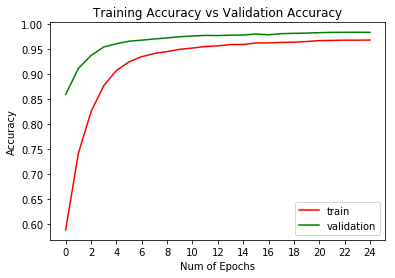

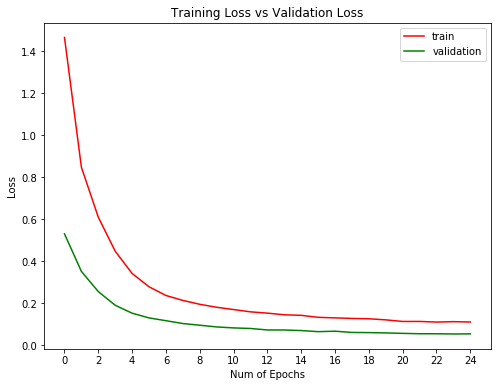

In [10]:
plt.figure(2)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, maxepochs+1, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(3)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, maxepochs+1, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

In [13]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 98.32%


In [15]:
model.save('MNIST_Classifier_v3.model')